In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import torch
import os

from pathlib import PurePath
from sklearn import metrics as skmetrics

import vxs
import vxs.utils as vxsu

In [2]:
avp_set_fixed = vxs.AVPTrackSet('../data/avp-dataset/AVP_Dataset/', subset='Fixed')
avp_set_personal = vxs.AVPTrackSet('../data/avp-dataset/AVP_Dataset', subset='Personal')

../data/avp-dataset/AVP_Dataset/Personal/Participant_20/P20_HHclosed_Personal.wav


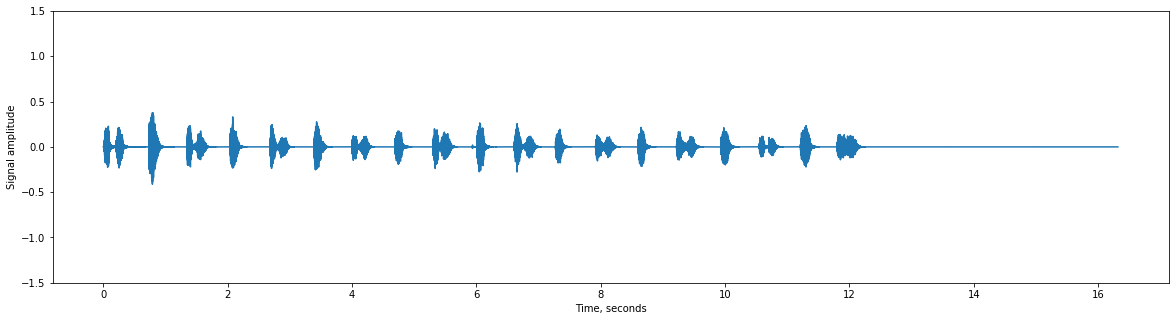

In [3]:
track, anno = avp_set_personal.get('P20_HHclosed_Personal')
vxsu.display_track(track)

In [5]:
fixed_segments = vxs.SegmentSet(avp_set_fixed, frame_window=None)

In [6]:
min_segm_lens = dict((cl, 100000) for cl in ['kd', 'sd', 'hhc', 'hho'])
for segm, cl in fixed_segments:
    min_segm_lens[cl] = min(min_segm_lens[cl], segm.n_samples)

In [7]:
min_segm_lens

{'kd': 3839, 'sd': 4287, 'hhc': 1400, 'hho': 2169}

In [8]:
max_segm_lens = dict((cl, 0) for cl in ['kd', 'sd', 'hhc', 'hho'])
for segm, cl in fixed_segments:
    max_segm_lens[cl] = max(max_segm_lens[cl], segm.n_samples)

In [9]:
max_segm_lens

{'kd': 579120, 'sd': 581744, 'hhc': 628327, 'hho': 580672}

In [10]:
participants = list(range(1, 29))
participant_segments = {}

In [11]:
df = pd.DataFrame(columns=['track', 'min_diff', 'max_diff', 'duration'])
for p in participants:
    #for cl, clname in class_map.items():
    ds = vxs.AVPTrackSet('../data/avp-dataset/AVP_Dataset/', subset='Fixed', participant=p)
    for track, anno in ds.annotated_tracks():
        times = np.concatenate((anno['time'].values, [track.duration]))
        diffs = times[1:] - times[:-1]
        t_name = PurePath(track.filepath).stem 
        df.loc[len(df)] = [t_name, diffs.min(), diffs.max(), track.duration]
df

,track,min_diff,max_diff,duration
0,P1_Snare_Fixed,0.129887,0.738685,10.718549
1,P1_HHopened_Fixed,0.135692,0.714014,11.449615
2,P1_Kick_Fixed,0.148571,0.919002,10.831746
3,P1_HHclosed_Fixed,0.135782,0.700408,11.894422
4,P1_Improvisation_Fixed,0.327800,0.697143,9.494422
...,...,...,...,...
135,P28_Snare_Fixed,0.160000,0.695692,16.526803
136,P28_Kick_Fixed,0.146395,0.756463,16.428118
137,P28_HHclosed_Fixed,0.151156,0.698413,16.718367
138,P28_Improvisation_Fixed,0.133878,0.815238,26.470748


### Generated stuff

In [74]:
gen_set = vxs.GenTrackSet('../data_temp/avp-gen-2/')
len(gen_set)

50

../data_temp/avp-gen-2/avp_p1_fixed_8.wav


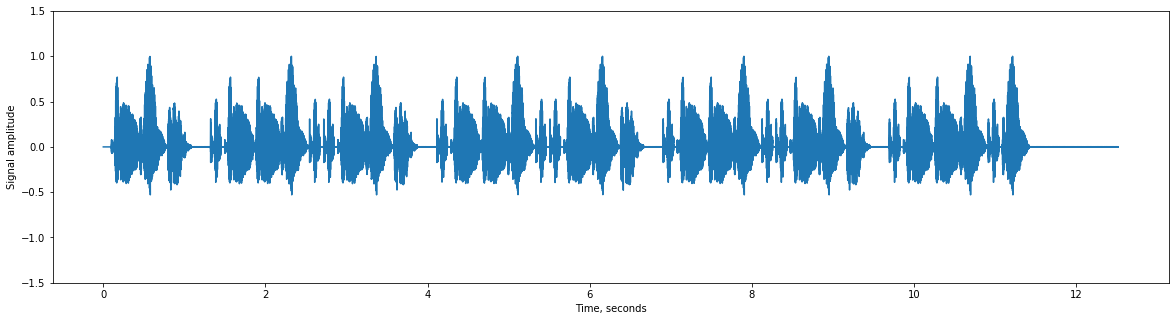

In [77]:
track, anno = gen_set.get(10)
vxsu.display_track(track)

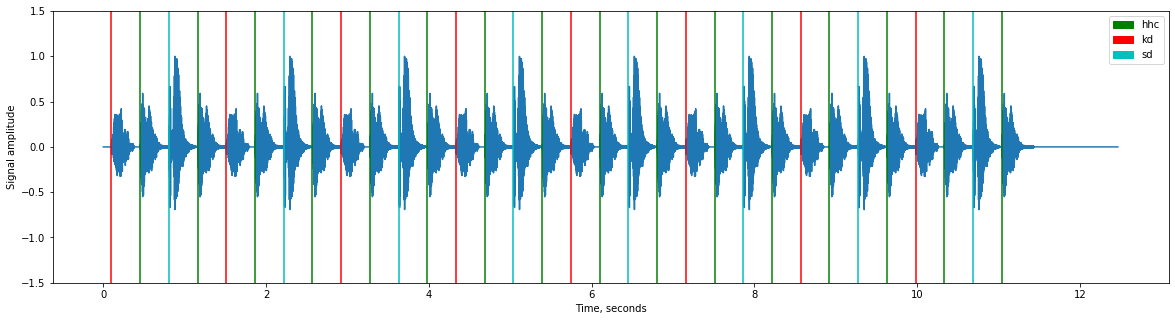

In [11]:
vxsu.plot_track(track, onsets=anno, color_events=True)

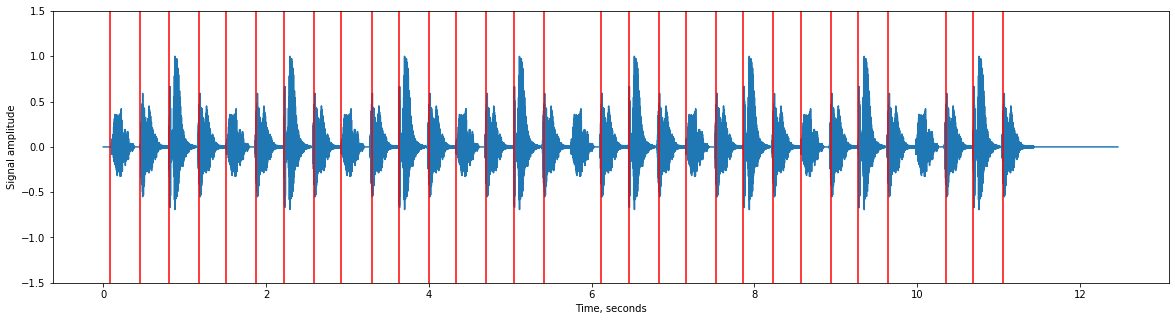

In [12]:
onsets = vxs.detect_onsets(track, method='complex')
vxsu.plot_track(track, onsets=onsets)

In [13]:
avp_segments_fixed_p6_28 = vxs.SegmentSet(vxs.AVPTrackSet(
    '../data/avp-dataset/AVP_Dataset/', subset='Fixed', participant=np.arange(6,29), recordings_type='hits'))

In [14]:
len(avp_segments_fixed_p6_28)

2764

In [15]:
X, y = vxsu.unzip_dataset(avp_segments_fixed_p6_28)
model = vxs.make_knn_classic('mfcc', n_neighbors=15, weights='distance')
model.fit(X, y)

Pipeline(steps=[('features', ClassicFeatureTransformer(feature_type='mfcc')),
                ('normalizer', Normalizer()),
                ('knn',
                 KNeighborsClassifier(n_neighbors=15, weights='distance'))])

In [16]:
res_nolang = vxs.segment_classify(track, model)

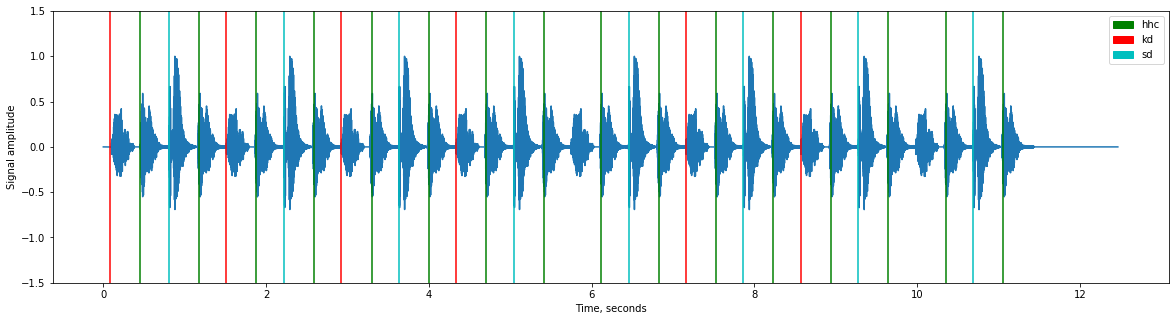

In [17]:
vxsu.plot_track(track, onsets=res_nolang['onsets'], color_events=True)

In [18]:
lang_model = vxs.load_model_from_bundle('../data/drum_kit_rnn.mag')

'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.
INFO:tensorflow:Restoring parameters from /tmp/tmpudbwon3b/model_drum_kit.ckpt


INFO:tensorflow:Beam search yields sequence with log-likelihood: 5.216799 


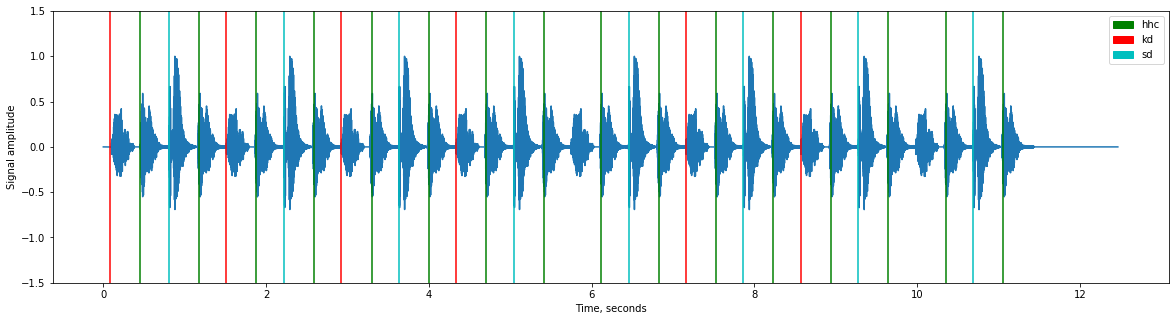

In [19]:
res_lang = vxs.segment_classify(track, model, lang_model, steps_per_iteration=4)
vxsu.plot_track(track, onsets=res_lang['onsets'], color_events=True)

In [36]:
mfcc_cf, mfcc_scores = vxs.segment_classify_all(gen_set, model, predefined_bpm=True,
                                                quantization_conflict_resolution=None)

Analysing tracks: 50it [00:30,  1.63it/s]


In [37]:
mfcc_cf

,hhc,hho,kd,sd,sil
hhc,823.0,1.0,0.0,180.0,192.0
hho,86.0,66.0,0.0,0.0,0.0
kd,0.0,0.0,420.0,0.0,187.0
sd,0.0,0.0,85.0,309.0,4.0
sil,233.0,21.0,0.0,2.0,0.0


In [38]:
mfcc_scores

,prec,rec,F1
hhc,0.720665,0.688127,0.704021
hho,0.75,0.434211,0.55
kd,0.831683,0.691928,0.755396
sd,0.629328,0.776382,0.695163


In [39]:
mfcc_scores.mean()

prec    0.732919
rec     0.647662
F1      0.676145
dtype: float64

In [40]:
lang_cf, lang_scores = vxs.segment_classify_all(gen_set, model, lang_model, predefined_bpm=True,
                                                steps_per_iteration=4, beam_size=5)

Analysing tracks: 0it [00:00, ?it/s]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 10.635727 


Analysing tracks: 1it [00:01,  1.78s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -19.327877 


Analysing tracks: 2it [00:03,  1.61s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 38.707213 


Analysing tracks: 3it [00:06,  2.27s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 52.318369 


Analysing tracks: 4it [00:09,  2.27s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 37.178631 


Analysing tracks: 5it [00:11,  2.24s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -17.881432 


Analysing tracks: 6it [00:12,  1.91s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 8.451398 


Analysing tracks: 7it [00:13,  1.68s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 12.885102 


Analysing tracks: 8it [00:14,  1.59s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 19.763558 


Analysing tracks: 9it [00:16,  1.65s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 4.517400 


Analysing tracks: 10it [00:17,  1.46s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 66.066269 


Analysing tracks: 11it [00:23,  2.91s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 73.678942 


Analysing tracks: 12it [00:26,  2.67s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 21.733374 


Analysing tracks: 13it [00:27,  2.36s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 4.957521 


Analysing tracks: 14it [00:29,  2.32s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 74.182906 


Analysing tracks: 15it [00:32,  2.27s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 36.106080 


Analysing tracks: 16it [00:34,  2.18s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -15.713459 


Analysing tracks: 17it [00:35,  2.01s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 11.254568 


Analysing tracks: 18it [00:37,  2.01s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 83.128544 


Analysing tracks: 19it [00:40,  2.17s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 17.449894 


Analysing tracks: 20it [00:43,  2.45s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 24.060450 


Analysing tracks: 21it [00:45,  2.39s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 21.519556 


Analysing tracks: 22it [00:47,  2.22s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 0.919827 


Analysing tracks: 23it [00:49,  2.25s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 12.117997 


Analysing tracks: 24it [00:51,  2.09s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 28.024267 


Analysing tracks: 25it [00:54,  2.41s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 10.659432 


Analysing tracks: 26it [00:56,  2.27s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 57.341258 


Analysing tracks: 27it [01:03,  3.62s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 20.847063 


Analysing tracks: 28it [01:06,  3.51s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 35.739054 


Analysing tracks: 29it [01:09,  3.29s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 50.963630 


Analysing tracks: 30it [01:11,  2.92s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -12.509942 


Analysing tracks: 31it [01:13,  2.58s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 84.004068 


Analysing tracks: 32it [01:20,  3.85s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -9.454875 


Analysing tracks: 33it [01:21,  3.21s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 29.092574 


Analysing tracks: 34it [01:24,  3.00s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 18.710653 


Analysing tracks: 35it [01:25,  2.61s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 51.181499 


Analysing tracks: 36it [01:28,  2.50s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 51.470238 


Analysing tracks: 37it [01:32,  3.04s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 11.051443 


Analysing tracks: 38it [01:34,  2.63s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 112.708149 


Analysing tracks: 39it [01:37,  2.87s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 16.361107 


Analysing tracks: 40it [01:39,  2.72s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 31.964315 


Analysing tracks: 41it [01:41,  2.40s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 16.199917 


Analysing tracks: 42it [01:43,  2.15s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 7.848458 


Analysing tracks: 43it [01:44,  2.02s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 25.746672 


Analysing tracks: 44it [01:46,  2.01s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 15.140445 


Analysing tracks: 45it [01:48,  1.93s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 30.779658 


Analysing tracks: 46it [01:50,  2.02s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 5.983013 


Analysing tracks: 47it [01:51,  1.73s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 22.021969 


Analysing tracks: 48it [01:53,  1.69s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 33.268154 


Analysing tracks: 49it [01:56,  2.15s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 95.097441 


Analysing tracks: 50it [01:59,  2.38s/it]


In [41]:
lang_cf

,hhc,hho,kd,sd,sil
hhc,819.0,0.0,0.0,180.0,197.0
hho,80.0,72.0,0.0,0.0,0.0
kd,0.0,0.0,420.0,0.0,187.0
sd,0.0,0.0,134.0,258.0,6.0
sil,228.0,20.0,0.0,2.0,0.0


In [42]:
lang_scores

,prec,rec,F1
hhc,0.726708,0.684783,0.705123
hho,0.782609,0.473684,0.590164
kd,0.758123,0.691928,0.723514
sd,0.586364,0.648241,0.615752


In [43]:
lang_scores.mean()

prec    0.713451
rec     0.624659
F1      0.658638
dtype: float64

In [88]:
lang_cf2, lang_scores2 = vxs.segment_classify_all(gen_set, model, lang_model, predefined_bpm=True,
                                                  steps_per_iteration=4, beam_size=10, silence_prob=0.01)

Analysing tracks: 0it [00:00, ?it/s]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -65.500341 


Analysing tracks: 1it [00:20, 20.78s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -64.953074 


Analysing tracks: 2it [00:31, 17.67s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -21.245562 


Analysing tracks: 3it [00:52, 18.62s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -24.027652 


Analysing tracks: 4it [00:58, 14.92s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -87.879636 


Analysing tracks: 5it [01:06, 13.00s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -12.274304 


Analysing tracks: 6it [01:09, 10.05s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -26.290272 


Analysing tracks: 7it [01:15,  8.64s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -50.331495 


Analysing tracks: 8it [01:18,  6.95s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -47.203371 


Analysing tracks: 9it [01:22,  6.18s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -32.009699 


Analysing tracks: 10it [01:25,  5.20s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -90.419319 


Analysing tracks: 11it [01:38,  7.52s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -130.403923 


Analysing tracks: 12it [01:45,  7.25s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -41.725054 


Analysing tracks: 13it [01:48,  5.98s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -109.962678 


Analysing tracks: 14it [01:55,  6.49s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -21.294443 


Analysing tracks: 15it [01:58,  5.24s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -9.438965 


Analysing tracks: 16it [02:09,  7.09s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -25.102832 


Analysing tracks: 17it [02:11,  5.50s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -57.744001 


Analysing tracks: 18it [02:14,  4.82s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -82.177550 


Analysing tracks: 19it [02:20,  5.12s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -23.251446 


Analysing tracks: 20it [02:25,  5.19s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -61.162830 


Analysing tracks: 21it [02:29,  4.78s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -20.520019 


Analysing tracks: 22it [02:32,  4.21s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -62.684466 


Analysing tracks: 23it [02:47,  7.33s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -41.816743 


Analysing tracks: 24it [02:55,  7.60s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -8.189173 


Analysing tracks: 25it [03:02,  7.44s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -45.643521 


Analysing tracks: 26it [03:07,  6.75s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -29.191248 


Analysing tracks: 27it [03:14,  6.95s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -46.104291 


Analysing tracks: 28it [03:18,  5.89s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -27.437154 


Analysing tracks: 29it [03:25,  6.27s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -50.032383 


Analysing tracks: 30it [03:37,  8.02s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -101.687456 


Analysing tracks: 31it [03:42,  7.18s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -35.244225 


Analysing tracks: 32it [03:50,  7.28s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -28.291768 


Analysing tracks: 33it [04:09, 10.85s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -43.839295 


Analysing tracks: 34it [04:13,  8.81s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -57.341621 


Analysing tracks: 35it [04:20,  8.30s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -38.198438 


Analysing tracks: 36it [04:24,  6.86s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -46.504495 


Analysing tracks: 37it [04:29,  6.35s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -71.566289 


Analysing tracks: 38it [04:33,  5.56s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -115.524365 


Analysing tracks: 39it [04:45,  7.58s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -30.522891 


Analysing tracks: 40it [04:48,  6.31s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -68.427200 


Analysing tracks: 41it [04:53,  5.77s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -48.995818 


Analysing tracks: 42it [04:59,  5.90s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -81.148474 


Analysing tracks: 43it [05:02,  5.17s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -121.711246 


Analysing tracks: 44it [05:08,  5.39s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -42.769332 


Analysing tracks: 45it [05:13,  5.24s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -42.134351 


Analysing tracks: 46it [05:21,  5.94s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -47.088736 


Analysing tracks: 47it [05:25,  5.47s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -38.902786 


Analysing tracks: 48it [05:29,  4.96s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -43.179117 


Analysing tracks: 49it [05:46,  8.61s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -30.993687 


Analysing tracks: 50it [06:03,  7.28s/it]


In [89]:
lang_cf2

,hhc,hho,kd,sd,sil
hhc,767.0,2.0,0.0,174.0,110.0
hho,222.0,105.0,0.0,0.0,8.0
kd,1.0,0.0,419.0,9.0,325.0
sd,17.0,0.0,64.0,303.0,3.0
sil,148.0,0.0,1.0,8.0,0.0


In [90]:
lang_scores2

,prec,rec,F1
hhc,0.664069,0.728395,0.694746
hho,0.981308,0.313433,0.475113
kd,0.865702,0.555703,0.676898
sd,0.61336,0.782946,0.687855


In [91]:
lang_scores2.mean()

prec    0.781110
rec     0.595119
F1      0.633653
dtype: float64

### Sanity check: using ground-truth onsets

In [78]:
trueonsets_mfcc_cf, trueonsets_mfcc_scores = vxs.segment_classify_all(
    gen_set, model, predefined_bpm=True, predefined_onsets=True)

Analysing tracks: 50it [00:29,  1.70it/s]


In [79]:
trueonsets_mfcc_cf

,hhc,hho,kd,sd,sil
hhc,323.0,2.0,0.0,40.0,0.0
hho,126.0,56.0,0.0,0.0,0.0
kd,0.0,0.0,1007.0,0.0,0.0
sd,40.0,0.0,176.0,322.0,0.0
sil,0.0,0.0,0.0,0.0,0.0


In [80]:
trueonsets_mfcc_scores

,prec,rec,F1
hhc,0.660532,0.884932,0.75644
hho,0.965517,0.307692,0.466667
kd,0.851226,1,0.919635
sd,0.889503,0.598513,0.715556


In [81]:
trueonsets_mfcc_scores.mean()

prec    0.841694
rec     0.697784
F1      0.714574
dtype: float64

In [82]:
trueonsets_lang_cf, trueonsets_lang_scores = vxs.segment_classify_all(
    gen_set, model, lang_model, predefined_bpm=True, predefined_onsets=True, steps_per_iteration=4)

Analysing tracks: 0it [00:00, ?it/s]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 92.356465 


Analysing tracks: 1it [00:03,  3.82s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -27.917286 


Analysing tracks: 2it [00:06,  3.41s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 21.835499 


Analysing tracks: 3it [00:09,  3.27s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -3.143904 


Analysing tracks: 4it [00:11,  2.99s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -40.793998 


Analysing tracks: 5it [00:17,  3.78s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 42.052927 


Analysing tracks: 6it [00:19,  3.30s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 92.990045 


Analysing tracks: 7it [00:24,  3.72s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 27.053904 


Analysing tracks: 8it [00:27,  3.51s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 21.630184 


Analysing tracks: 9it [00:29,  3.26s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 23.820174 


Analysing tracks: 10it [00:31,  2.88s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 26.357731 


Analysing tracks: 11it [00:34,  2.96s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 4.705810 


Analysing tracks: 12it [00:37,  2.95s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 67.786299 


Analysing tracks: 13it [00:41,  3.12s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 16.794022 


Analysing tracks: 14it [00:45,  3.31s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 43.145149 


Analysing tracks: 15it [00:49,  3.59s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 56.578922 


Analysing tracks: 16it [00:52,  3.52s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -12.208764 


Analysing tracks: 17it [00:57,  3.87s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 14.297835 


Analysing tracks: 18it [00:59,  3.23s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 10.936909 


Analysing tracks: 19it [01:02,  3.35s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 84.024271 


Analysing tracks: 20it [01:08,  3.98s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 80.745367 


Analysing tracks: 21it [01:11,  3.65s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 3.965713 


Analysing tracks: 22it [01:15,  3.76s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 63.403843 


Analysing tracks: 23it [01:20,  4.25s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 42.243283 


Analysing tracks: 24it [01:24,  4.09s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 41.304526 


Analysing tracks: 25it [01:30,  4.74s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -12.390143 


Analysing tracks: 26it [01:33,  4.27s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -6.767810 


Analysing tracks: 27it [01:36,  3.93s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 99.937702 


Analysing tracks: 28it [01:45,  5.33s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 35.488375 


Analysing tracks: 29it [01:53,  6.30s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -24.710148 


Analysing tracks: 30it [01:56,  5.27s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 68.211217 


Analysing tracks: 31it [02:00,  4.69s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 57.209989 


Analysing tracks: 32it [02:03,  4.38s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 36.564531 


Analysing tracks: 33it [02:06,  3.95s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 8.258044 


Analysing tracks: 34it [02:10,  3.85s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -12.500625 


Analysing tracks: 35it [02:13,  3.76s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 30.113579 


Analysing tracks: 36it [02:16,  3.33s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 28.497922 


Analysing tracks: 37it [02:18,  2.90s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 61.816125 


Analysing tracks: 38it [02:21,  2.96s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -20.751072 


Analysing tracks: 39it [02:23,  2.66s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -53.656444 


Analysing tracks: 40it [02:27,  3.17s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -5.919549 


Analysing tracks: 41it [02:30,  3.08s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 14.436083 


Analysing tracks: 42it [02:32,  2.91s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 73.101698 


Analysing tracks: 43it [02:36,  2.99s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 16.837883 


Analysing tracks: 44it [02:39,  2.97s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -10.540480 


Analysing tracks: 45it [02:40,  2.66s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 50.806703 


Analysing tracks: 46it [02:44,  2.85s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 0.300111 


Analysing tracks: 47it [02:47,  3.00s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 2.626200 


Analysing tracks: 48it [02:49,  2.74s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: 14.954718 


Analysing tracks: 49it [02:53,  2.93s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -5.641607 


Analysing tracks: 50it [02:56,  3.52s/it]


In [83]:
trueonsets_lang_cf

,hhc,hho,kd,sd,sil
hhc,316.0,9.0,0.0,40.0,0.0
hho,113.0,69.0,0.0,0.0,0.0
kd,0.0,0.0,1007.0,0.0,0.0
sd,39.0,0.0,229.0,270.0,0.0
sil,0.0,0.0,0.0,0.0,0.0


In [84]:
trueonsets_lang_scores

,prec,rec,F1
hhc,0.675214,0.865753,0.758703
hho,0.884615,0.379121,0.530769
kd,0.814725,1,0.897905
sd,0.870968,0.501859,0.636792


In [85]:
trueonsets_lang_scores.mean()

prec    0.811380
rec     0.686683
F1      0.706042
dtype: float64

In [ ]:
cae_wide = vxs.get_CAE_model('wide-4', '../logs/cae-initial_65536_wide-4/checkpoints/best.pth')
model_cae = vxs.make_knn_cae(cae_wide, n_neighbors=15, weights='distance')
model_cae.fit(X, y)

In [27]:
cwide_cf, cwide_scores = vxs.segment_classify_all(gen_set, model_cae, predefined_bpm=True,
                                                  quantization_conflict_resolution=None)

Analysing tracks: 50it [01:16,  1.53s/it]


In [28]:
cwide_cf

,hhc,hho,kd,sd,sil
hhc,367.0,0.0,113.0,472.0,101.0
hho,146.0,85.0,0.0,104.0,0.0
kd,0.0,0.0,421.0,22.0,311.0
sd,50.0,0.0,237.0,99.0,1.0
sil,8.0,0.0,8.0,151.0,0.0


In [40]:
cwide_cf.loc['hho', 'hhc']

146.0

In [29]:
cwide_scores

,prec,rec,F1
hhc,0.348528,0.642732,0.45197
hho,0.253731,1,0.404762
kd,0.558355,0.540436,0.54925
sd,0.255814,0.116745,0.160324


In [30]:
cwide_scores.mean()

prec    0.354107
rec     0.574978
F1      0.391577
dtype: float64

In [31]:
lang_cw_cf, lang_cw_scores = vxs.segment_classify_all(gen_set, model_cae, lang_model, predefined_bpm=True,
                                                      steps_per_iteration=4, beam_size=5)

Analysing tracks: 0it [00:00, ?it/s]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -79.467619 


Analysing tracks: 1it [00:30, 30.23s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -92.954670 


Analysing tracks: 2it [00:36, 22.97s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -55.412680 


Analysing tracks: 3it [00:48, 19.75s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -38.034865 


Analysing tracks: 4it [00:52, 14.89s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -110.428432 


Analysing tracks: 5it [00:56, 11.82s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -40.534127 


Analysing tracks: 6it [00:59,  9.08s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -69.598919 


Analysing tracks: 7it [01:02,  7.44s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -48.961862 


Analysing tracks: 8it [01:06,  6.34s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -64.315867 


Analysing tracks: 9it [01:09,  5.36s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -34.227495 


Analysing tracks: 10it [01:11,  4.31s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -139.103029 


Analysing tracks: 11it [01:20,  5.70s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -129.145971 


Analysing tracks: 12it [01:25,  5.40s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -56.952572 


Analysing tracks: 13it [01:27,  4.39s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -96.760351 


Analysing tracks: 14it [01:31,  4.40s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -49.759155 


Analysing tracks: 15it [01:33,  3.64s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -78.774110 


Analysing tracks: 16it [01:53,  8.51s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -24.128610 


Analysing tracks: 17it [01:55,  6.39s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -72.078921 


Analysing tracks: 18it [01:57,  5.20s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -99.996665 


Analysing tracks: 19it [02:02,  5.23s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -36.340344 


Analysing tracks: 20it [02:06,  4.81s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -72.015766 


Analysing tracks: 21it [02:09,  4.30s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -42.342292 


Analysing tracks: 22it [02:11,  3.67s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -58.836558 


Analysing tracks: 23it [02:19,  4.91s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -71.787585 


Analysing tracks: 24it [02:24,  4.99s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -53.077088 


Analysing tracks: 25it [02:35,  6.67s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -62.115231 


Analysing tracks: 26it [02:38,  5.68s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -38.096362 


Analysing tracks: 27it [02:43,  5.29s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -64.972465 


Analysing tracks: 28it [02:45,  4.48s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -58.203970 


Analysing tracks: 29it [02:52,  5.04s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -79.563095 


Analysing tracks: 30it [02:59,  5.80s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -97.022107 


Analysing tracks: 31it [03:02,  4.97s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -68.924187 


Analysing tracks: 32it [03:06,  4.48s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -54.180359 


Analysing tracks: 33it [03:16,  6.28s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -36.515571 


Analysing tracks: 34it [03:18,  5.06s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -67.882079 


Analysing tracks: 35it [03:23,  4.83s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -26.888749 


Analysing tracks: 36it [03:25,  4.24s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -62.564333 


Analysing tracks: 37it [03:29,  4.02s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -80.499788 


Analysing tracks: 38it [03:32,  3.73s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -112.854177 


Analysing tracks: 39it [03:48,  7.39s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -46.363079 


Analysing tracks: 40it [03:50,  5.88s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -71.055798 


Analysing tracks: 41it [03:54,  5.10s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -72.473395 


Analysing tracks: 42it [03:57,  4.56s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -98.406987 


Analysing tracks: 43it [03:59,  3.88s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -101.510722 


Analysing tracks: 44it [04:04,  4.08s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -56.525251 


Analysing tracks: 45it [04:07,  3.72s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -68.054468 


Analysing tracks: 46it [04:12,  4.22s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -57.922741 


Analysing tracks: 47it [04:15,  3.83s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -61.715265 


Analysing tracks: 48it [04:17,  3.44s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -44.473912 


Analysing tracks: 49it [04:28,  5.59s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -56.881484 


Analysing tracks: 50it [04:38,  5.57s/it]


In [32]:
lang_cw_cf

,hhc,hho,kd,sd,sil
hhc,420.0,0.0,85.0,442.0,106.0
hho,142.0,27.0,18.0,145.0,3.0
kd,2.0,0.0,355.0,83.0,314.0
sd,82.0,0.0,150.0,153.0,2.0
sil,4.0,0.0,8.0,148.0,0.0


In [33]:
lang_cw_scores

,prec,rec,F1
hhc,0.39886,0.646154,0.493247
hho,0.080597,1,0.149171
kd,0.470822,0.576299,0.518248
sd,0.395349,0.15757,0.225331


In [34]:
lang_cw_scores.mean()

prec    0.336407
rec     0.595006
F1      0.346500
dtype: float64

#### Cutting AVP dataset into chunks

In [ ]:
savedir_f = '../data_temp/avp-cut/fixed/participant_{}/'

for p in participants:
    participant_segments[p] = {}
    ds = vxs.SegmentSet(vxs.AVPTrackSet('../data/avp-dataset/AVP_Dataset/', subset='Fixed',
                                        participant=p, recordings_type='hits'), frame_window=None)
    pdir = savedir_f.format(p)
    os.makedirs(pdir, exist_ok=True)
    cls_counters = {}
    for i in range(len(ds)):
        segm, cl = ds[i]
        try:
            cl_i = cls_counters[cl]
        except KeyError:
            cls_counters[cl] = 0
            cl_i = 0
        segm.save((pdir + f'{cl}_{cl_i}.wav'))
        cls_counters[cl] += 1